<a href="https://colab.research.google.com/github/NayelySaldivar/DesafioData/blob/main/BasesDeDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Desafío Data México </h2>
<h4> <p> Segunda Edición - Datos con perspectiva de género </p> </h4> 

##### Importación de librerías:

In [2]:
import pandas as pd
import numpy as np
import requests
import plotly.express as px
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga y modificación de las bases:

### - Resultados Covid desde la plataforma **DataMexico**:

- Utilizamos la **DataMexico API Explorer** para obtener los datos actualizados:

In [ ]:
data=requests.get('https://api.datamexico.org/tesseract/cubes/gobmx_covid/aggregate.jsonrecords?drilldowns%5B%5D=Death+Date.Death+Date.Death+Date&drilldowns%5B%5D=Covid+Result.Covid+Result.Covid+Result&drilldowns%5B%5D=Health+Institution+Attended.Health+Institution+Attended.Health+Institution+Attended&drilldowns%5B%5D=Pneumonia+Diagnose.Pneumonia+Diagnose.Pneumonia+Diagnose&drilldowns%5B%5D=COPD+Diagnose.COPD+Diagnose.COPD+Diagnose&drilldowns%5B%5D=Asthma+Diagnose.Asthma+Diagnose.Asthma+Diagnose&drilldowns%5B%5D=Inmunosupresion+Diagnose.Inmunosupresion+Diagnose.Inmunosupresion+Diagnose&drilldowns%5B%5D=Hypertension+Diagnose.Hypertension+Diagnose.Hypertension+Diagnose&drilldowns%5B%5D=Cardiovascular+Diagnose.Cardiovascular+Diagnose.Cardiovascular+Diagnose&drilldowns%5B%5D=Obesity+Diagnose.Obesity+Diagnose.Obesity+Diagnose&drilldowns%5B%5D=Chronic+Kidney+Failure+Diagnose.Chronic+Kidney+Failure+Diagnose.Chronic+Kidney+Failure+Diagnose&drilldowns%5B%5D=Diabetes+Diagnose.Diabetes+Diagnose.Diabetes+Diagnose&drilldowns%5B%5D=State+Patient+Attended.State+Patient+Attended.State+Patient+Attended&drilldowns%5B%5D=State+Patient+Origin.State+Patient+Origin.State+Patient+Origin&drilldowns%5B%5D=Sex.Sex.Sex&drilldowns%5B%5D=Age+Group.Age+Group.Age&drilldowns%5B%5D=Municipality+Patient+Residence.Geography.Municipality&measures%5B%5D=Cases&parents=false&sparse=false')
data_api=pd.DataFrame(data.json()["data"])

In [ ]:
data_api.head(3)

Death Date ID  Death Date  ...  Municipality Cases
0       20200102  2020-01-02  ...    Iztapalapa     1
1       20200103  2020-01-03  ...       Tijuana     1
2       20200103  2020-01-03  ...      Saltillo     1

[3 rows x 34 columns]

In [ ]:
data_api.shape

(263200, 34)

### - Datos históricos de **Mortalidad 2012-2019** del INEGI:

In [ ]:
# hist_muertes=pd.read_csv(f'defunciones_generales_{2012}.csv')
hist_muertes=pd.read_csv(f'/content/drive/MyDrive/DesafioData/defunciones_generales_{2012}.csv')
hist_muertes['date']='2012'

for i in range(2013,2020):
    aux=pd.read_csv(f'/content/drive/MyDrive/DesafioData/defunciones_generales_{i}.csv')
    # aux=pd.read_csv(f'defunciones_generales_{i}.csv')
    aux['date']=i
    hist_muertes=pd.concat([hist_muertes,aux])

hist_muertes=hist_muertes.reset_index(drop=True)

In [ ]:
hist_muertes.tail(3)

ent_regis  mun_regis causa_def  ... rel_emba  area_ur  date
5374487         32         56      X999  ...        8        9  2019
5374488         32         37      X954  ...        8        9  2019
5374489         32         56      J09X  ...        8        1  2019

[3 rows x 18 columns]

In [ ]:
hist_muertes[hist_muertes['date']==2019].shape

(747784, 18)

Transformamos el formato de la **edad**:

In [ ]:
hist_muertes['edad_real']=np.where(hist_muertes['edad']>4000,hist_muertes['edad']-4000,-1)
# hist_muertes[hist_muertes['edad_real']==-1]

Eliminamos los registros que carecen de esta información ya que también cuentan con vacíos en otras variables:

In [ ]:
rows_sin_edad=list(hist_muertes[hist_muertes['edad_real']==-1].index)
print(f'Coincidencias: {len(rows_sin_edad)}')
print(f'Shape Inicial:{hist_muertes.shape}')
hist_muertes=hist_muertes.drop(rows_sin_edad,axis=0)
print(f'Shape Final:{hist_muertes.shape}')

hist_muertes=hist_muertes.reset_index(drop=True)

Coincidencias: 205810
Shape Inicial:(5374490, 19)
Shape Final:(5168680, 19)


Nuestra investigación se concentra en el estudio de la población femenina por lo que es necesario limpiar también la variable de **sexo**:

In [ ]:
rows_sin_sex=list(hist_muertes[hist_muertes['sexo']==9].index)

print(f'Coincidencias: {len(rows_sin_sex)}')
print(f'Shape Inicial:{hist_muertes.shape}')
hist_muertes=hist_muertes.drop(rows_sin_sex,axis=0)
print(f'Shape Final:{hist_muertes.shape}')

hist_muertes=hist_muertes.reset_index(drop=True)

Coincidencias: 2408
Shape Inicial:(5168680, 19)
Shape Final:(5166272, 19)


### - Catálogo de enfermedades según la **CIE - 10**

Concatenamos todas las incidencias:

In [ ]:
cat_enfermedad=pd.read_csv(f'/content/drive/MyDrive/DesafioData/decatcausa{2012}.csv', encoding='latin-1')

for i in range(2013,2020):
    aux=pd.read_csv(f'/content/drive/MyDrive/DesafioData/decatcausa{i}.csv',encoding='latin-1')
    cat_enfermedad=pd.concat([cat_enfermedad,aux])
    
cat_enfermedad=cat_enfermedad.reset_index()

Creamos los diccionarios para encontrar las claves únicas:

In [ ]:
claves_duplicadas={}

for i in range(len(cat_enfermedad)):
    claves_duplicadas[cat_enfermedad['CVE'][i]]=str(cat_enfermedad['DESCRIP'][i])
    
dict_no_duplicados = {} 
for key, value in claves_duplicadas.items(): 
    if not value in dict_no_duplicados.values(): 
        dict_no_duplicados[key] = value 

Archivamos para usar en el script principal:

In [ ]:
claves=pd.DataFrame(list(dict_no_duplicados.keys()),columns=['Clave'])  

desc=[]
for i in claves['Clave'][:-1]:
    desc.append(dict_no_duplicados[str(i)])
    
descr=pd.DataFrame(pd.Series(desc),columns=['Dictamen'])

catalogo_completo=pd.concat([claves,descr],axis=1)

catalogo_completo.to_csv('Catalogo_CIE_10.csv')

#### - Segmentación de padecimientos

In [ ]:
EPOC=["J44"+str(i) for i in range(0,10)]

asma=["J450","J451","J458","J459","J46X"]
# cardiovascular=["I0"+str(i)+str(j) for i in range(5,10) for j in range(0,10)]+\ # Cardiopatía reumática
# ["I10X"]+["I1"+str(i)+str(j) for i in range(0,6) for j in range(0,10)]+\ # Hipertensión Arterial
# ["I42X"]+["I42"+str(i)+str(j)  for i in range(0,10) for j in range(0,10)]+\ # Miocardiopatías
# ["I50X"]+["I50"+str(i)+str(j)  for i in range(0,10) for j in range(0,10)]+\ # Insuficiencia cardiaca
# ["I60X"]+["I"+str(i)+str(j)  for i in range(60,70) for j in range(0,10)] +\ # Enfermedad cerebrovascular
# ["I70X","I80X"]+["I"+str(i)+str(j)  for i in range(70,90) for j in range(0,10)] +\ # Enfermedad vascular perifería
# ["Q20X"]+["Q2"+str(i)+str(j)  for i in range(0,9) for j in range(0,10)] # Cardiopatía congénita

cardiovascular=["I0"+str(i)+str(j) for i in range(5,10) for j in range(0,10)]+ \
["I20X"]+["I2"+str(i)+str(j) for i in range(0,6) for j in range(0,10)]+ \
["I42X"]+["I42"+str(i) for i in range(0,10)]+\
["I50X"]+["I50"+str(i)  for i in range(0,10)]+\
["I60X"]+["I"+str(i)+str(j)  for i in range(60,70) for j in range(0,10)] +\
["I70X","I80X"]+["I"+str(i)+str(j)  for i in range(70,90) for j in range(0,10)] +\
["Q20X"]+["Q2"+str(i)+str(j)  for i in range(0,9) for j in range(0,10)] 

hipertension=['G932','I270','I272','K766','O10X','O11X','O13X','O14X','O16X','P292']+ \
["I10X"]+["I1"+str(i)+str(j) for i in range(0,6) for j in range(0,10)]+ \
["O"+str(i)+str(j) for i in range(10,15) for j in range(0,10)]+\
["O16"+str(i) for i in range(0,10)]

diabetes=["E1"+str(i)+str(j) for i in range(0,5) for j in range(0,10)]+['E232','N251','P702']+["O24"+str(i) for i in range(0,10)]

neumonia=["J1"+str(i)+str(j) for i in range(0,9) for j in range(0,10)]+['J851']+["P23"+str(i) for i in range(0,10)]

insuf_renal=["N1"+str(i)+str(j) for i in range(7,10) for j in range(0,10)]+["I17X","I18X","I19X"]+['P960']

obesidad=["E66"+str(i) for i in range(0,10)]

'''VIH [B20-B24] + Cáncer [C0-C97] + Rechazo de trasplantes [T86] ''' 
inmunosup=["B"+str(i)+str(j) for i in range(20,25) for j in range(0,10)]+['B24X','O987','R75X']+\
["C00"+str(i) for i in range(0,10)]+["C0"+str(i) for i in range(10,100)]+["C"+str(i)+str(j) for i in range(10,97) for j in range(0,10)]+\
["D00"+str(i) for i in range(0,10)]+["D0"+str(i) for i in range(10,100)]+\
["D"+str(i)+str(j) for i in range(80,90) for j in range(0,10)]+\
["T86"+str(i) for i in range(0,10)]

Añadimos el grupo a la base de mortalidad:

In [ ]:
hist_muertes['gpo_enfermedad']=np.where(hist_muertes['causa_def'].isin(EPOC),'EPOC',
                                               np.where(hist_muertes['causa_def'].isin(asma),'asma',
                                                 np.where(hist_muertes['causa_def'].isin(cardiovascular),'cardiovascular',
                                                   np.where(hist_muertes['causa_def'].isin(hipertension),'hipertension',
                                                     np.where(hist_muertes['causa_def'].isin(diabetes),'diabetes',
                                                       np.where(hist_muertes['causa_def'].isin(neumonia),'neumonia',
                                                         np.where(hist_muertes['causa_def'].isin(insuf_renal),'insuf_renal',
                                                           np.where(hist_muertes['causa_def'].isin(obesidad),'obesidad',
                                                              np.where(hist_muertes['causa_def'].isin(inmunosup),'inmunosupresores','otros'
                                             )
                                             )
                                             )
                                             )
                                             )
                                             )
                                             )
                                             )
                                             )

In [ ]:
# hist_muertes[['gpo_enfermedad','causa_def']].head(3)
# hist_muertes.groupby(['gpo_enfermedad','sexo'])['edad'].count()

### - **Regiones Nielsen**

**Área I: Pacífico** - Baja California Norte, Baja California Sur, Sonora, Sinaloa, Nayarit (5) - [2, 3, 26, 25, 18]

**Área II: Norte** - Chihuahua, Coahuila, Durango, Nuevo León, San Luis Potosí,Tamaulipas, Zacatecas (7) - [8, 5, 10, 19, 24, 28, 32]

**Área III: Bajío** -  Aguascalientes, Jalisco, Guanajuato, Colima, Michoacan (5) - [1, 14, 11, 6, 16]

**Área IV: Centro** - Hidalgo, Querétaro, Morelos, Edo. México, Tlaxcala, Puebla, Guerrero (7) - [13, 22, 17, 15, 29, 21, 12]

**Área V**: Valle de México - Cdmx (1) - [9]


**Área VI**: Sureste - Chiapas, Campeche, Yucatan, Quintana Roo, Veracruz, Oaxaca, Tabasco (7) - [7, 4, 31, 23, 30, 20, 27]

In [ ]:
pacifico = [2, 3, 26, 25, 18]
norte = [8, 5, 10, 19, 24, 28, 32]
bajio = [1, 14, 11, 6, 16]
centro = [13, 22, 17, 15, 29, 21, 12]
vallem = [9]
sureste = [7, 4, 31, 23, 30, 20, 27]

Añadimos la región a la base de mortalidad:

In [ ]:
hist_muertes['region']=np.where(hist_muertes['ent_regis'].isin(pacifico),'pacifico',
                                      np.where(hist_muertes['ent_regis'].isin(norte),'norte',
                                               np.where(hist_muertes['ent_regis'].isin(bajio),'bajio',
                                                np.where(hist_muertes['ent_regis'].isin(centro),'centro',
                                                         np.where(hist_muertes['ent_regis'].isin(vallem),'vallem',
                                                             np.where(hist_muertes['ent_regis'].isin(sureste),'sureste','revisar' 
                                                                  )
                                                             )
                                                       )
                                                  )
                                              )
                                        )

In [ ]:
hist_muertes.groupby('region')['edad'].count()

region
bajio        878828
centro      1284247
norte        922959
pacifico     469595
sureste     1047342
vallem       563301
Name: edad, dtype: int64

Archivamos los cambios para usar en el script principal:

In [ ]:
hist_muertes.to_csv("Bases_INEGI.csv")

### - Resultados de **Censo Nacional de Población 2020** realizado por el INEGI:

In [4]:
inegi2020=pd.read_csv('/content/drive/MyDrive/DesafioData/inegi2020_con_clavegeo.csv')

In [5]:
inegi2020.columns

Index(['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'AGEB', 'MZA',
       'POBTOT', 'POBFEM',
       ...
       'VPH_CEL', 'VPH_INTER', 'VPH_STVP', 'VPH_SPMVPI', 'VPH_CVJ',
       'VPH_SINRTV', 'VPH_SINLTC', 'VPH_SINCINT', 'VPH_SINTIC', 'CVEGEO'],
      dtype='object', length=230)

In [7]:
pd.DataFrame(inegi2020['NOM_ENT'].value_counts())

NOM_ENT
México                            133820
Jalisco                            97527
Veracruz de Ignacio de la Llave    89308
Nuevo León                         68298
Chihuahua                          67664
Puebla                             66310
Ciudad de México                   65649
Michoacán de Ocampo                64784
Guanajuato                         62992
Sonora                             60112
Tamaulipas                         58897
Guerrero                           54200
Baja California                    53272
Coahuila de Zaragoza               52492
Chiapas                            50866
Oaxaca                             46398
Sinaloa                            43554
Hidalgo                            36683
Yucatán                            35500
San Luis Potosí                    35027
Durango                            31027
Zacatecas                          29241
Morelos                            27655
Querétaro                          27548
Quintana Roo                       23665
Nayarit                            19140
Tabasco                            16249
Tlaxcala                           16093
Baja California Sur                16070
Aguascalientes                     14899
Colima                             13039
Campeche                           11082

### - **Extracto de Mujeres** del histórico de mortalidad:

In [ ]:
mortalidad_mujeres=hist_muertes[hist_muertes['sexo']==2]
mortalidad_mujeres.to_csv('Bases_INEGI_Mujeres.csv')

In [ ]:
mortalidad_mujeres.shape

(2272081, 21)

In [ ]:
hist_muertes.shape

(5166272, 21)

### - Tranformación para el modelo

In [ ]:
!pip install feature_engine

Debido a la cantidad de datos y los recursos con los que contamos, decidimos tomar el último quiquenio que tenemos registrado en e histórico de muertes para crear nuestro modelo de ML

In [ ]:
data_mujeres_quinquenio = mortalidad_mujeres[mortalidad_mujeres['date'].isin([2015,2016,2017,2018,2019])].reset_index(drop=True)

Volvemos dummies las variables de los grupos de enfermedad:

In [ ]:
data_mujeres=data_mujeres_quinquenio['gpo_enfermedad']

In [ ]:
dum_df = pd.get_dummies(data_mujeres, columns=['gpo_enfermedad'], prefix="Gpo_Enfermedad_is")
# dum_df.head(3)

Guardamos las variables que coinciden con la base de COVID:

In [ ]:
data_mujeres=pd.concat([dum_df,data_mujeres_quinquenio[['sexo','edad_real','derechohab','ent_regis','mun_regis']]],axis=1)
data_mujeres.head(2)

Gpo_Enfermedad_is_EPOC  Gpo_Enfermedad_is_asma  ...  ent_regis  mun_regis
0                       0                       0  ...          1          1
1                       0                       0  ...          1          1

[2 rows x 15 columns]

In [ ]:
rows_to_drop=data_mujeres[data_mujeres['Gpo_Enfermedad_is_otros']==1].index
data_mujeres_limpia=data_mujeres.copy()

print(f'Shape Inicial: {data_mujeres_limpia.shape}')
data_mujeres_limpia=data_mujeres_limpia.drop(rows_to_drop,axis=0).reset_index(drop=True)
data_mujeres_limpia=data_mujeres_limpia.drop('Gpo_Enfermedad_is_otros',axis=1)
print(f'Shape Inicial: {data_mujeres_limpia.shape}')

Shape Inicial: (1488372, 15)
Shape Inicial: (988232, 14)


Datos Covid-19

In [ ]:
data=requests.get('https://api.datamexico.org/tesseract/cubes/gobmx_covid/aggregate.jsonrecords?drilldowns%5B%5D=Death+Date.Death+Date.Death+Date&drilldowns%5B%5D=Covid+Result.Covid+Result.Covid+Result&drilldowns%5B%5D=Health+Institution+Attended.Health+Institution+Attended.Health+Institution+Attended&drilldowns%5B%5D=Pneumonia+Diagnose.Pneumonia+Diagnose.Pneumonia+Diagnose&drilldowns%5B%5D=COPD+Diagnose.COPD+Diagnose.COPD+Diagnose&drilldowns%5B%5D=Asthma+Diagnose.Asthma+Diagnose.Asthma+Diagnose&drilldowns%5B%5D=Inmunosupresion+Diagnose.Inmunosupresion+Diagnose.Inmunosupresion+Diagnose&drilldowns%5B%5D=Hypertension+Diagnose.Hypertension+Diagnose.Hypertension+Diagnose&drilldowns%5B%5D=Cardiovascular+Diagnose.Cardiovascular+Diagnose.Cardiovascular+Diagnose&drilldowns%5B%5D=Obesity+Diagnose.Obesity+Diagnose.Obesity+Diagnose&drilldowns%5B%5D=Chronic+Kidney+Failure+Diagnose.Chronic+Kidney+Failure+Diagnose.Chronic+Kidney+Failure+Diagnose&drilldowns%5B%5D=Diabetes+Diagnose.Diabetes+Diagnose.Diabetes+Diagnose&drilldowns%5B%5D=State+Patient+Attended.State+Patient+Attended.State+Patient+Attended&drilldowns%5B%5D=State+Patient+Origin.State+Patient+Origin.State+Patient+Origin&drilldowns%5B%5D=Sex.Sex.Sex&drilldowns%5B%5D=Age+Group.Age+Group.Age&drilldowns%5B%5D=Municipality+Patient+Residence.Geography.Municipality&measures%5B%5D=Cases&parents=false&sparse=false')
data_api=pd.DataFrame(data.json()["data"])
print(data_api.shape)

(263200, 34)


In [ ]:
# data_api.head(2)

Homologamos los valores dummies de la base:

In [ ]:
enfermedades=['Pneumonia Diagnose ID','COPD Diagnose ID','Asthma Diagnose ID','Inmunosupresion Diagnose ID','Hypertension Diagnose ID','Cardiovascular Diagnose ID','Obesity Diagnose ID','Chronic Kidney Failure Diagnose ID','Diabetes Diagnose ID']

for enf in enfermedades:

  data_api[enf]=np.where(data_api[enf]==1,1,0)

In [ ]:
# Orden de las columnas
# columnas_ml=['EPOC','Asma','Cardiovascular','Diabetes','Hipertension','Inmunosupresion','Inf_Renal','Neumonia','Obesidad','Sexo','Edad','Institucion','Estado','Municipio']
data_api_ml_completo=data_api[['COPD Diagnose ID','Asthma Diagnose ID','Cardiovascular Diagnose ID','Diabetes Diagnose ID','Hypertension Diagnose ID','Inmunosupresion Diagnose ID','Chronic Kidney Failure Diagnose ID','Pneumonia Diagnose ID','Obesity Diagnose ID','Sex ID','Age','Health Institution Attended','State Patient Attended ID','Municipality ID']]

In [ ]:
data_api_ml_completo['Health Institution Attended']=np.where(
    data_api_ml_completo['Health Institution Attended']=='IMSS',2,np.where(
    data_api_ml_completo['Health Institution Attended']=='ISSSTE',3,np.where(
    data_api_ml_completo['Health Institution Attended']=='PEMEX',4,np.where(
    data_api_ml_completo['Health Institution Attended']=='SEDENA',5,np.where(
    data_api_ml_completo['Health Institution Attended']=='SEMAR',6,np.where(
    data_api_ml_completo['Health Institution Attended']=='IMSS-Bienestar',7,8    
    )    
    )
    )    
    )    
    )
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_api_ml_completo.head()

COPD Diagnose ID  ...  Municipality ID
0                 0  ...             9007
1                 0  ...             2004
2                 0  ...             5030
3                 0  ...            26018
4                 1  ...            13070

[5 rows x 14 columns]

In [ ]:
# data_api_ml_completo.to_csv('Base_Covid_2003.csv')

## Unsupervised ML - Clusterización 

Tenemos nuestras bases completas, ahora hay que homologar el nombre de las columnas:

In [ ]:
data_inegi_ml=data_mujeres_limpia.copy().drop('sexo',axis=1)
data_api_ml=data_api_ml_completo[data_api_ml_completo['Sex ID']==2].drop('Sex ID',axis=1).reset_index(drop=True)

columnas_ml=['EPOC','Asma','Cardiovascular','Diabetes','Hipertension','Inmunosupresion','Inf_Renal','Neumonia','Obesidad','Edad','Institucion','Estado','Municipio']
data_inegi_ml.columns=columnas_ml
data_api_ml.columns=columnas_ml

### K Means

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Con ayuda el elbow method buscamos el número de clusters óptimo para la partición:

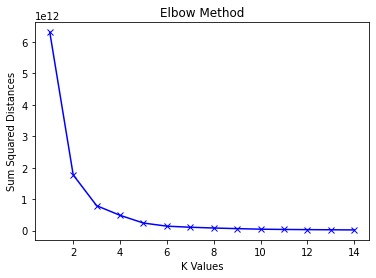

In [ ]:
K = range(1,15)
sum_squared_distances = []
for k in K:
  model = KMeans(n_clusters=k).fit(data_api_ml)
  sum_squared_distances.append(model.inertia_)
plt.plot(K, sum_squared_distances, "bx-")
plt.xlabel("K Values")
plt.ylabel("Sum Squared Distances")
plt.title("Elbow Method")
plt.show()

Identificamos 4 clusters

In [ ]:
kmeans = KMeans(n_clusters=4)
data_api_clusters = kmeans.fit(data_api_ml)
preds = data_api_clusters.fit_predict(data_api_ml)

Marcamos cada cluster en la base con la columna **cluster**:

In [ ]:
data_api_ml['Cluster']=preds
data_api_ml.head(2)

EPOC  Asma  Cardiovascular  ...  Estado  Municipio  Cluster
0     0     0               0  ...       9       9007        0
1     0     0               0  ...       5       5030        0

[2 rows x 14 columns]

In [ ]:
data_api_ml[data_api_ml.Cluster==0].Estado.value_counts()

9     14281
2      3951
8      3546
5      3373
1      1174
10     1078
7       706
3       624
6       576
15      524
4       502
26       60
27       44
19       41
13       30
14       19
31       18
21       16
30       13
25       11
22        8
32        7
16        5
11        5
20        4
18        4
17        4
12        3
24        2
23        2
29        1
Name: Estado, dtype: int64

### DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

Con ayuda de NN identificamos la distancia óptima

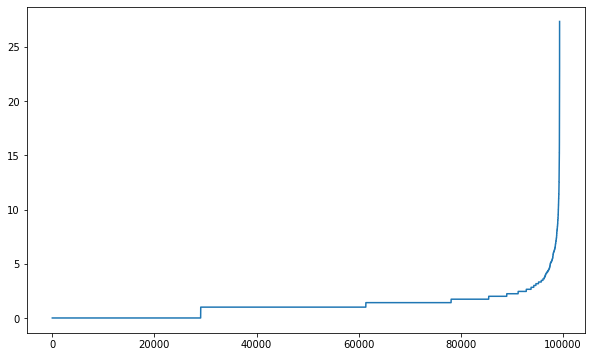

In [ ]:
nearest_neighbors = NearestNeighbors(n_neighbors=100)
nearest_neighbors.fit(data_api_ml.drop('Cluster',axis=1))
distances, indices = nearest_neighbors.kneighbors(data_api_ml.drop('Cluster',axis=1))
distances = np.sort(distances, axis=0)[:,1]
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.show()

Creamos el modelo:

In [ ]:
m = DBSCAN(eps=3, min_samples=28)
m.fit(data_api_ml.drop('Cluster',axis=1))

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=28, n_jobs=None, p=None)

Creamos los cluster y etiquetamos el ruido.

In [ ]:
#Asignar nuestros labels/clusters
labels = m.labels_

#Empezar a enmascarar nuestros datos
labels_mask_general = np.zeros_like(labels,dtype=bool)

#Colocar outliers como verdadero
labels_mask_general[m.core_sample_indices_] = True

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters: {n_clusters}')
print(f'Registros con ruido: {n_noise}')

Número de clusters: 121
Registros con ruido: 35776


In [ ]:
data_api_ml['Cluster_DBSCAN']=labels
data_api_ml.head(2)

EPOC  Asma  Cardiovascular  ...  Municipio  Cluster  Cluster_DBSCAN
0     0     0               0  ...       9007        0               0
1     0     0               0  ...       5030        0               1

[2 rows x 15 columns]

Analicemos los clusters:

### HDBSCAN

In [ ]:
pip install hdbscan

In [ ]:
import sklearn.cluster as cluster
import scipy.cluster.hierarchy as sch
import hdbscan
from random import sample 

Para la visualización del dendograma y visualizar los parámetros de clusterización tomaremos una muestra aleatoria de los datos:

In [ ]:
muestra_hdbscan=data_api_ml.drop(['Cluster','Cluster_DBSCAN'],axis=1).sample(frac=.1)

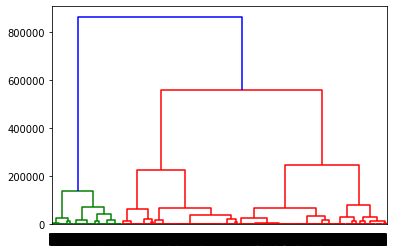

In [ ]:
dendogram = sch.dendrogram(sch.linkage(muestra_hdbscan,method='ward'))
plt.title('Dendogram')
plt.xlabel('Customers')
plt.ylabel('Distancia Euclidiana')
plt.show()

Tomando la distancia vertical más larga y contando las veces que cruza con otras ramos, obtenemos que el tamaño minimo de los clusters debe ser de . 
Ejecutamos el modelo con esos parámetros:

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
m.fit(data_api_ml.drop(['Cluster','Cluster_DBSCAN'],axis=1))

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=28, n_jobs=None, p=None)

In [ ]:
# Asignar nuestros labels/clusters
labels = m.labels_

# Empezar a enmascarar nuestros datos
labels_mask_general = np.zeros_like(labels,dtype=bool)

# Colocar outliers como verdadero
labels_mask_general[m.core_sample_indices_] = True

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters: {n_clusters}')
print(f'Registros con ruido: {n_noise}')

Número de clusters: 121
Registros con ruido: 35776


Asignamos los labels obtenidos:

In [ ]:
data_api_ml['Cluster_HDBSCAN']=labels
data_api_ml.head(2)

EPOC  Asma  Cardiovascular  ...  Cluster  Cluster_DBSCAN  Cluster_HDBSCAN
0     0     0               0  ...        0               0                0
1     0     0               0  ...        0               1                1

[2 rows x 16 columns]

### GMM

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

Para obtener el número de componentes, obtenemos el valor de las 4 covarianzas.

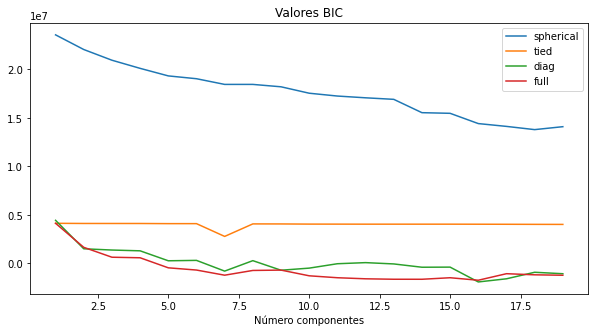

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

n_components = range(1, 20)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GMM(n_components=i, covariance_type=covariance_type, random_state=123)
        modelo = modelo.fit(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1))
        valores_bic.append(modelo.bic(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1)))
        
    ax.plot(n_components, valores_bic, label=covariance_type)
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();

Corremos el modelo con el número de componentes = . 

In [ ]:
gm  = GMM(n_components=7, covariance_type='full')
gm.fit(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1))

labels = gm.predict(data_api_ml.drop(['Cluster','Cluster_DBSCAN','Cluster_HDBSCAN'],axis=1))
data_api_ml['Cluster_GMM']= labels
data_api_ml.head(2)

EPOC  Asma  Cardiovascular  ...  Cluster_DBSCAN  Cluster_HDBSCAN  Cluster_GMM
0     0     0               0  ...               0                0            1
1     0     0               0  ...               1                1            2

[2 rows x 17 columns]

In [ ]:
data_api_ml['Cluster_GMM'].value_counts()

2    74581
5     9949
1     5682
0     4263
6     3140
3     1404
4      327
Name: Cluster_GMM, dtype: int64

In [ ]:
data_api_ml.to_csv('Cluster_Covid.csv')